In [1]:
# pip install azure-ai-textanalytics

In [2]:
import os

# This example requires environment variables named "LANGUAGE_KEY" and "LANGUAGE_ENDPOINT"
language_key = os.environ.get('LANGUAGE_KEY')
# "411dab1a118f4719bf8f48d8b4dc5cc1"
language_endpoint = os.environ.get('LANGUAGE_ENDPOINT')
# "https://nlpoc.cognitiveservices.azure.com/"

In [3]:
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

In [4]:
# Authenticate the client using your key and endpoint 
def authenticate_client():
    ta_credential = AzureKeyCredential(language_key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=language_endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

In [5]:
# 2. Fonction pour analyser le sentiment d'un texte
def sentiment_analysis(client, documents):
    sentiments = []
    batch_size = 10  # Azure ne permet pas plus de 10 documents par requête

    for i in range(0, len(documents), batch_size):
        batch = documents[i:i + batch_size]  # Diviser les documents en lots de 10
        response = client.analyze_sentiment(documents=batch)
        for doc in response:
            if not doc.is_error:
                sentiment = 0 if doc.sentiment == "positive" else 1
                sentiments.append(sentiment)
            else:
                sentiments.append(None)  # Pour gérer les erreurs éventuelles
    return sentiments

In [6]:
# 3. Analyser le dataframe
def add_sentiment_column(data, column):
    client = authenticate_client()
    documents = data[column].tolist()  # Extraire les textes à analyser
    sentiments = sentiment_analysis(client, documents)  # Analyser le sentiment
    
    new_column_name = f"azure_sentiment_{column}"  # Concaténer azure_sentiment avec le nom de la colonne
    data[new_column_name] = sentiments  # Ajouter les résultats comme nouvelle colonne
    
    return data

In [7]:
import pandas as pd
data = pd.read_csv("./data/test_df.csv", index_col=0)

In [8]:
# Ajouter la colonne 'sentiment'
data = add_sentiment_column(data, "text")
data.head()

,target,ids,date,flag,user,text,sentiment_score,cleaned_text,tokenized,preprocessed_text,preprocessed_tokenized,length_tokenized,length_preprocessed_tokenized,sia_sentiment,azure_sentiment_text
1211804,0,1989191567,Mon Jun 01 00:39:30 PDT 2009,NO_QUERY,philhawley,"@SDNPhotography Good thanks, just on the coach...",4,"<mention> Good thanks, just on the coach back ...","['<mention>', 'Good', 'thanks', ',', 'just', '...",<mention> good thanks coach back airport tak...,"['<', 'mention', '>', 'good', 'thanks', 'coach...",18,12,0,0
750666,1,2285740575,Mon Jun 22 15:31:08 PDT 2009,NO_QUERY,the_dream,"@Justin_Steele I had a 3G, with dev 3.0, bough...",0,"<mention> I had a 3G, with dev 3.0, bought a 3...","['<mention>', 'I', 'had', 'a', '3G', ',', 'wit...",<mention> 3g dev 30 bought 3gs 30 tried upg...,"['<', 'mention', '>', '3g', 'dev', '30', 'boug...",32,16,1,1
864971,0,1677379144,Sat May 02 01:46:25 PDT 2009,NO_QUERY,hey_tc,@darrenmckay You need to upgrade your mug to a...,4,<mention> You need to upgrade your mug to a lo...,"['<mention>', 'You', 'need', 'to', 'upgrade', ...",<mention> need upgrade mug longer lasting one,"['<', 'mention', '>', 'need', 'upgrade', 'mug'...",12,9,1,1
890709,0,1688819410,Sun May 03 11:59:47 PDT 2009,NO_QUERY,ellejonees,nothing and nothing...noone online?missing NY!...,4,Nothing and nothing.noone online?missing NY! N...,"['Nothing', 'and', 'nothing.noone', 'online', ...",nothing nothingnoone online ? missing ny ! im ...,"['nothing', 'nothingnoone', 'online', '?', 'mi...",23,18,0,1
1242043,0,1994144099,Mon Jun 01 11:28:58 PDT 2009,NO_QUERY,mixedupstate,"Really excited...pikcing ally up from airport,...",4,"Really excited.pikcing allay up from airport, ...","['Really', 'excited.pikcing', 'allay', 'up', '...",really excitedpikcing allay airport jim 's co...,"['really', 'excitedpikcing', 'allay', 'airport...",26,15,0,0


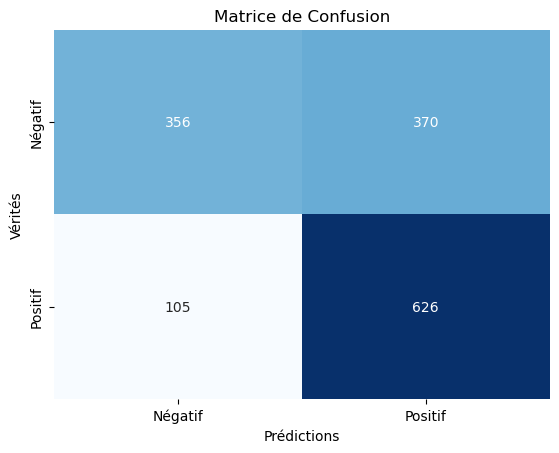

Rapport de Classification:

              precision    recall  f1-score   support

     Négatif       0.77      0.49      0.60       726
     Positif       0.63      0.86      0.72       731

    accuracy                           0.67      1457
   macro avg       0.70      0.67      0.66      1457
weighted avg       0.70      0.67      0.66      1457

Accuracy Moyenne: 0.67
Adjusted Rand Index (ARI): 0.12


In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Afficher la matrice de confusion
def plot_confusion_matrix(data):
    y_true = data['target']  # Labels réels
    y_pred = data['azure_sentiment_text']  # Prédictions
    cm = confusion_matrix(y_true, y_pred)  # Calculer la matrice de confusion
    
    # Afficher la matrice de confusion avec seaborn pour une meilleure visualisation
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Négatif', 'Positif'], 
                yticklabels=['Négatif', 'Positif'])
    plt.xlabel('Prédictions')
    plt.ylabel('Vérités')
    plt.title('Matrice de Confusion')
    plt.show()

# 2. Afficher le rapport de classification et l'accuracy
def print_classification_report(data):
    y_true = data['target']  # Labels réels
    y_pred = data['azure_sentiment_text']  # Prédictions
    report = classification_report(y_true, y_pred, target_names=['Négatif', 'Positif'])
    accuracy = accuracy_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    
    print("Rapport de Classification:\n")
    print(report)
    print(f"Accuracy Moyenne: {accuracy:.2f}")
    print(f"Adjusted Rand Index (ARI): {ari:.2f}")

# Afficher la matrice de confusion
plot_confusion_matrix(data)

# Afficher le rapport de classification et l'accuracy
print_classification_report(data)


In [10]:
# Ajouter la colonne 'sentiment'
data = add_sentiment_column(data, "preprocessed_text")

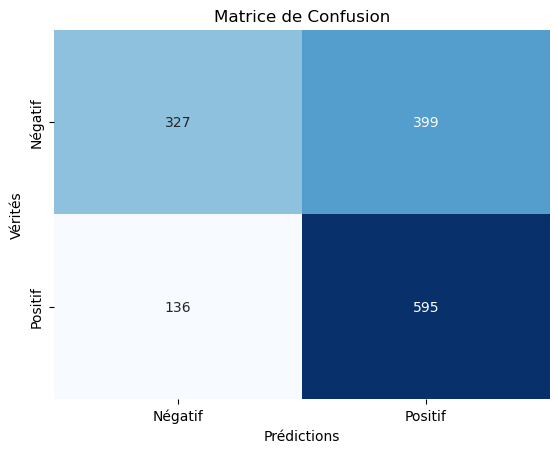

Rapport de Classification:

              precision    recall  f1-score   support

     Négatif       0.71      0.45      0.55       726
     Positif       0.60      0.81      0.69       731

    accuracy                           0.63      1457
   macro avg       0.65      0.63      0.62      1457
weighted avg       0.65      0.63      0.62      1457



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Afficher la matrice de confusion
def plot_confusion_matrix(data):
    y_true = data['target']  # Labels réels
    y_pred = data['azure_sentiment_preprocessed_text']  # Prédictions
    cm = confusion_matrix(y_true, y_pred)  # Calculer la matrice de confusion
    
    # Afficher la matrice de confusion avec seaborn pour une meilleure visualisation
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Négatif', 'Positif'], 
                yticklabels=['Négatif', 'Positif'])
    plt.xlabel('Prédictions')
    plt.ylabel('Vérités')
    plt.title('Matrice de Confusion')
    plt.show()

# 2. Afficher le rapport de classification
def print_classification_report(data):
    y_true = data['target']  # Labels réels
    y_pred = data['azure_sentiment_preprocessed_text']  # Prédictions
    report = classification_report(y_true, y_pred, target_names=['Négatif', 'Positif'])
    print("Rapport de Classification:\n")
    print(report)

# Afficher la matrice de confusion
plot_confusion_matrix(data)

# Afficher le rapport de classification
print_classification_report(data)

A partir de la colonne "text" (non pré-traité): on a arrive à un taux de détection des positif élevé, mais en contrepartie la classe négative comporte de nombreuses erreurs ce qui résulte en un nombre important de faux positifs. Les faux négatifs sont très limités, ce qui est la tendance voulue: on ne veut pas louper les mauvaises appréciation. Dans ce modèle on a une vision pessimiste de l'appréciation des tweets.<br>
Le modèle depuis le texte prétraité possèlde les mêmes caractéristiques mais il est moins performant: l'exactitude de prédiction moyenne est légèrement inférieure.

In [12]:
data.to_csv("./data/test_azure.csv", index=True)